In [1]:
import nltk
import os
import re
import math
import pandas as pd
import numpy as np
import copy
import string
import random
import itertools
import time
import csv
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import axes3d, Axes3D
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [2]:
%matplotlib notebook

Time to pre-process3.6875


<IPython.core.display.Javascript object>


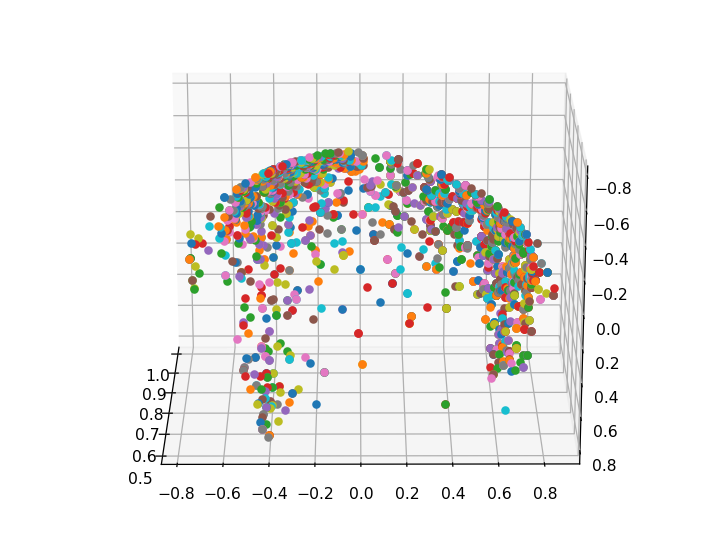

[[ 0.74461361  0.66657736  0.03500278]
 [ 0.74461361  0.66657736  0.03500278]
 [ 0.54947563  0.83511132 -0.02579941]
 ...
 [ 0.86989539 -0.13932532 -0.47314952]
 [ 0.70910168  0.63754756  0.30117753]
 [ 0.85275721  0.49387195 -0.16998716]]


In [3]:
all_texts=[]
Y = []
start = time.process_time()
# os.chdir("C://Users//Hp//Desktop//Projects//Text-Mining//bbcsport")
os.chdir("C://Users//Hp//Desktop//Projects//Text-Mining//Dataset-Hitech-Torch")
directories = os.listdir()
label = 0
for directory in directories:
    path = os.path.join(os.getcwd(),directory)
    os.chdir(path)
    files = os.listdir()
    temp = []
    for file in files:
        with open(file,'r') as curr_file:
            all_texts.append(curr_file.read())
            Y.append(label)
    label = label + 1
    os.chdir('..')
os.chdir('..')
path = os.path.join(os.getcwd(),"GWO")
os.chdir(path)
tfidf = TfidfVectorizer(all_texts, stop_words='english')
vectors = tfidf.fit_transform(all_texts)
all_words = tfidf.get_feature_names()
vectors_dense = vectors.todense()
svd = TruncatedSVD(n_components=3)
vectors_dense_svd = svd.fit_transform(vectors_dense)
vectors_dense_svd = Normalizer().fit_transform(vectors_dense_svd)
end = time.process_time()
print("Time to pre-process"+str(end-start))
fig=plt.figure()
X = vectors_dense_svd
random.shuffle(X)
ax = Axes3D(fig)
print(X)
for j in range(len(X)):
    ax.scatter(X[j][0], X[j][1], X[j][2], marker='o')
    ax.view_init(330, 140)
plt.show()

In [4]:
max_iter = 100 #Maximum number of iterations
N = 12         #Population size (In the range 5 to 12)
K = 5         #Number of clusters

In [5]:
def population_initialization():
    '''
    Parameters:
    Output:
        N wolves of length K*D where D is the number of features
    Function:
        Takes K random datapoints from the dataset and appends them to create a chromosome
        This is repeated N times
    '''
    wolves_pack=[]
    for i in range(N):
        wolf=[]
        for j in range(K):
            wolf.append(X[random.randint(0,len(X)-1)])
        wolf=list(itertools.chain(*wolf))
        wolves_pack.append(wolf)
    return wolves_pack

In [6]:
#Function to decide cluster using Euclidean distance
def cosine_similarity(centers,datapoint):
    '''
    Parameters:
        centers: List of Cluster centers
        K : number of clusters
        datapoint : Datapoint
    Output:
        Cluster number alloted based on maximum cosine_similarity of the datapoint with the cluster centers
    '''
    #Cosine Similarity    
    t = np.asarray(datapoint)
    normt= np.linalg.norm(t)
    dot=[]
    for i in range(K):
        temp_center = np.asarray(centers[i])
        normc = np.linalg.norm(temp_center)
        cos_sim_value=np.dot(t,temp_center)/(normt*normc)
        dot.append(cos_sim_value)
    
    return dot.index(max(dot))

In [7]:
def euclidean_dist_based_center_decision(centers,datapoint):
    t = np.asarray(datapoint)
    dist=[]
    for i in range(K):
        temp_center = np.asarray(centers[i])
        dist.append(np.sqrt(np.sum(np.square(temp_center-t))))
    return dist.index(min(dist))

In [8]:
def fitness_function(wolf):
    '''
    Input : wolf -> A 1 x d(number of documents) vector containing the initial population
    Output: theta -> Fitness value of each wolf
    '''
    centers=[]
    
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(wolf[i*len(X[0]):len(X[0])*(i+1)])
    
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
        clusters[cosine_similarity(centers,X[i])].append(X[i])
        
    n_components=2
    svd = TruncatedSVD(n_components)
    U  = []
    for i in range(K):
        if(len(clusters[i])!=0):
            U.append(svd.fit_transform(clusters[i]))
    
    theta=0
    for i in range(n_components):
        for j in range(len(U)):
            for k in range(len(U)):
                if k!=j and (U[k].shape)[1]==(U[j].shape)[1]:
                    t1 = U[j][:,i]
                    t2 = U[k][:,i]
                    diff = abs(t2.shape[0]-t1.shape[0])
                    if t1.shape[0] < t2.shape[0]:
                        t1 = np.append(t1, np.zeros(diff))
                    elif t1.shape[0] > t2.shape[0]:
                        t2 = np.append(t2, np.zeros(diff))
                    temp = np.dot(t1,t2)/(np.linalg.norm(t1)*np.linalg.norm(t2))
                    theta=theta+math.acos(temp)
    
    centers=[]
    for i in range(K):
        temp=clusters[i]
        if len(temp)!=0:
            centers.append((np.sum(np.asarray(temp),axis=0)/len(temp)).tolist())
        else:
            temp_list=X[random.randint(0,len(X)-1)]
            centers.append(temp_list)
    
    wolf =[]
    for i in range(len(centers)):
        wolf.extend(centers[i])
    fitness_score = theta
    return fitness_score,wolf

In [9]:
def fitness_evaluation(wolves):
    '''
    Input: wolves -> A N x d dimension matrix containing wolves
    Output:fitness-> A N x 1 dimension vector containing fitness values of all wolves
    '''
    fitness = []
    new_wolves=[]
    for i in range(len(wolves)):
        fit,wolf = fitness_function(wolves[i])
        fitness.append(fit)
        new_wolves.append(wolf)
    return fitness,new_wolves

In [10]:
def find_beta(wolves, fitness):
    alpha = max(fitness)
    beta  = -1000
    for i in fitness:
        if beta<i and i!=alpha:
            beta = i
    return wolves[fitness.index(beta)]

In [11]:
def find_gamma(wolves,fitness, beta):
    alpha = max(fitness)
    gamma = -10000
    for i in fitness:
        if gamma<i and i!=alpha and i!=beta:
            gamma = i
    return wolves[fitness.index(gamma)]

In [12]:
def grey_wolf_optimization():
    gen_fitness = []
    start = time.process_time()
    wolves = population_initialization()
    fitness,wolves= fitness_evaluation(wolves)
    alpha  = wolves[fitness.index(max(fitness))] 
    beta   = find_beta(wolves, fitness)
    gamma  = find_gamma(wolves, fitness, fitness[wolves.index(beta)])
    
    a = 2
    
    C1 = 2*np.random.random(size = len(alpha))
    C2 = 2*np.random.random(size = len(beta))
    C3 = 2*np.random.random(size = len(gamma))
    
    A1 = 2*a*np.random.random(size = len(alpha)) - a 
    A2 = 2*a*np.random.random(size = len(beta)) - a
    A3 = 2*a*np.random.random(size = len(gamma)) - a
    
    t = 0
    gen_vs_fitness = []
    stop_gwo = False
    while t<max_iter and not stop_gwo:
        for i in wolves:
            if i!=alpha and i!=beta and i!=gamma:
                D_alpha = np.linalg.norm(np.dot(C1,alpha)-i)
                D_beta  = np.linalg.norm(np.dot(C2,beta)-i)
                D_gamma = np.linalg.norm(np.dot(C3,gamma)-i)

                X1 = alpha - A1*D_alpha
                X2 = beta - A2*D_beta
                X3 = gamma - A3*D_gamma

                i = (X1+X2+X3)/3
        #-----------------------------------------------------
        a = 2 - t*(2/max_iter)
        
        C1 = 2*np.random.random(size = len(alpha))
        C2 = 2*np.random.random(size = len(beta))
        C3 = 2*np.random.random(size = len(gamma))

        A1 = 2*a*np.random.random(size = len(alpha)) - a 
        A2 = 2*a*np.random.random(size = len(beta)) - a
        A3 = 2*a*np.random.random(size = len(gamma)) - a
        
        t = t + 1
        
        fitnes, wolves = fitness_evaluation(wolves)
        temp = []
        temp.append(str(t))
        temp.append(str(max(fitnes)))
        gen_fitness.append(temp)
        print("Generation "+ str(t) + ": "+str(max(fitnes)))
        if t>2 and abs(max(fitnes)-gen_vs_fitness[-1])<0.001 and abs(max(fitnes)-gen_vs_fitness[-2])<0.001:
            stop_gwo=True
            print("Stopping GWO because same results over past 2 generations")
        else:
            gen_vs_fitness.append(max(fitnes))
        alpha  = wolves[fitnes.index(max(fitnes))] 
        beta   = find_beta(wolves, fitnes)
        gamma  = find_gamma(wolves, fitnes, fitnes[wolves.index(beta)])
    
    end = time.process_time()
    print("Time taken: " + str(end-start))
    with open('GWO with K='+str(K)+'.csv','w+') as csvFile:
        writer = csv.writer(csvFile)
        writer.writerows(gen_fitness)
    csvFile.close()
    return alpha

In [13]:
def intracluster_distances(wolf):
    centers=[]
    
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(wolf[i*len(X[0]):len(X[0])*(i+1)])
    
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
        clusters[cosine_similarity(centers,X[i])].append(X[i])
   
    intracluster_d=[]
    for i in range(K):
        M=0
        temp=clusters[i]
        center=centers[i]
        for j in temp:
            M+=np.linalg.norm(np.asarray(j)-np.asarray(center))
        if len(temp)==0:
            M=0
        else:
            M=M/len(temp)
        intracluster_d.append(M)
    return intracluster_d

In [14]:
def davies_bouldin_index(wolf):
    intra_distance = intracluster_distances(wolf)
    
    centers=[]
    #Dividing the wolves into centers
    for i in range(K):
        centers.append(wolf[i*len(X[0]):len(X[0])*(i+1)])
    
    D = []
    for i in range(K):
        R = []
        for j in range(K):
            if i!=j:
                M = np.linalg.norm(np.asarray(centers[i])-np.asarray(centers[j]))
                r = (intra_distance[i]+intra_distance[j])/M
                R.append(r)
        D.append(max(R))
    return (1/K)*(np.sum(np.asarray(D)))

In [15]:
def silhoutette_index(wolf):
    centers=[]
    #Dividing the wolves into centers
    for i in range(K):
        centers.append(wolf[i*len(X[0]):len(X[0])*(i+1)])
        
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
        clusters[cosine_similarity(centers,X[i])].append(X[i])
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])

    S = 0
    for i in range(K):
        for j in clusters[i]:
            a = 0
            b = 0
            t1 = np.asarray(j)
            for k in clusters[i]:
                t2 = np.asarray(k)
                a  = a + np.sqrt(np.sum(np.square(t1-t2)))
            for k in range(K):
                if i!=k:
                    for f in clusters[k]:
                        t2 = np.asarray(f)
                        b  = b + np.sqrt(np.sum(np.square(t1-t2)))
            s = (b-a)/max(a,b)
            S = S + s
    S = S/len(X)
    return S

In [16]:
def calinski_harabasz(wolf):
    centers=[]
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(wolf[i*len(X[0]):len(X[0])*(i+1)])
        
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
        clusters[cosine_similarity(centers,X[i])].append(X[i])
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
    
    #1. Calculating SSb:
    SSb = 0
    m = np.mean(X)
    for i in range(K):
        SSb += len(clusters[i])*np.square(np.linalg.norm(centers[i]-m))
    
    #2. Calculating SSw:
    SSw = 0
    for i in range(K):
        for j in clusters[i]:
            SSw += np.square(np.linalg.norm(j-centers[i]))
    
    ch_index = (SSb/SSw)*((len(X)-K)/(K-1))
    return ch_index

In [17]:
def dunn_index(wolf):
    centers=[]
    #Dividing the wolves into centers
    for i in range(K):
        centers.append(wolf[i*len(X[0]):len(X[0])*(i+1)])
        
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
        clusters[cosine_similarity(centers,X[i])].append(X[i])
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
    
    numerator = 10000000
    denominator=1
    for i in range(K):
        for j in range(K):
            if i!=j:
                numerator = min(numerator, np.sqrt(np.sum(np.square(np.asarray(centers[i])-np.asarray(centers[j])))))
    
    denominator = max(intracluster_distances(wolf))
    return numerator/denominator

In [18]:
def supervised_scores(wolf):
    centers=[]
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(wolf[i*len(X[0]):len(X[0])*(i+1)])
    
    Y_pred = []
    for i in range(len(X)):
        Y_pred.append(cosine_similarity(centers,X[i]))
#         Y_pred.append(euclidean_dist_based_center_decision(centers,X[i]))
    
    print(Y_pred)
    return f1_score(Y, Y_pred, average='micro'), accuracy_score(Y, Y_pred)    

In [19]:
def plot(wolf):
    centers=[]
    
    #Dividing the wolves into centers
    for i in range(K):
        centers.append(wolf[i*len(X[0]):len(X[0])*(i+1)])
        
   #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
#         clusters[cosine_similarity(centers,X[i])].append(X[i])
        clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
    
    for i in range(K):
        print(len(clusters[i]))
    colors=['#ff3333','#000000','#ffd933','#dd6622','#84ff33','#33ffee','#3395ff','#d2a8fc','#abcdef']
    fig=plt.figure()
    ax = Axes3D(fig)
    for i in range(K):
        temp=clusters[i]
        for j in temp:
            ax.scatter(j[0], j[1], j[2], c=colors[i], marker='o')
            ax.view_init(330, 140)
    for i in range(K):
        temp=clusters[i]
        ax.scatter(centers[i][0],centers[i][1],centers[i][2],c='b',marker='X')

Generation 1: 15.289079583078289
Generation 2: 15.418518885657278
Generation 3: 15.031723819743856
Generation 4: 15.291362933296455
Generation 5: 15.163602955539297
Generation 6: 15.06485105824437
Generation 7: 15.177474495248894
Generation 8: 15.247923181575457
Generation 9: 15.088123158256742
Generation 10: 15.064851058244372
Generation 11: 15.06485105824437
Generation 12: 15.064851058244372
Stopping GWO because same results over past 2 generations
Time taken: 28.625
DB Index        :0.7132815221144246
Silhoutte Index :0.6309965614638027
Calinski-Harabasz Index :8453.015243175083
247
1312
742


<IPython.core.display.Javascript object>


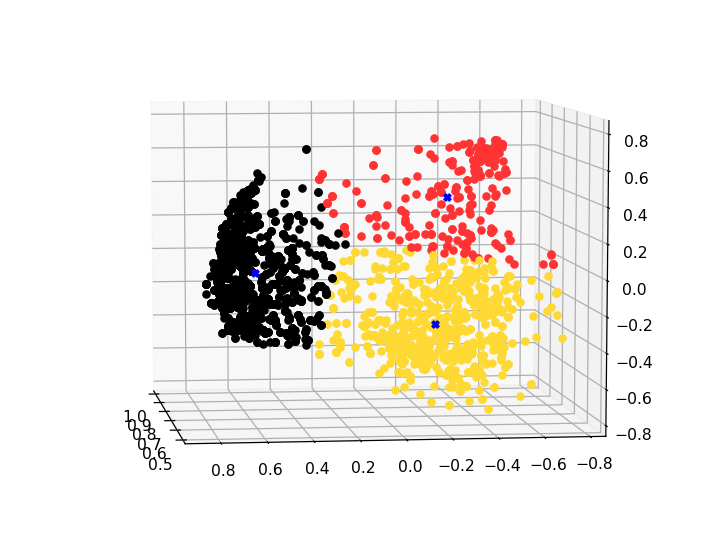

In [24]:
K = 3
alpha = grey_wolf_optimization()
print("DB Index        :"+str(davies_bouldin_index(alpha)))
print("Silhoutte Index :"+str(silhoutette_index(alpha)))
print("Calinski-Harabasz Index :"+str(calinski_harabasz(alpha)))
plot(alpha)

Generation 1: 54.01495785126384
Generation 2: 52.98707131994602
Generation 3: 52.62301265659454
Generation 4: 50.97927074598058
Generation 5: 49.74844136002042
Generation 6: 47.73727611357494
Generation 7: 45.93874574423871
Generation 8: 45.90983515453392
Generation 9: 46.37901316404626
Generation 10: 46.3696982655069
Generation 11: 46.19827930069813
Generation 12: 46.45715123762011
Generation 13: 46.58817964042495
Generation 14: 46.84668972348658
Generation 15: 46.84668972348658
Generation 16: 46.84668972348658
Stopping GWO because same results over past 2 generations
Time taken: 51.9375
DB Index        :0.9313740816943812
Silhoutte Index :0.8800596650531168
Calinski-Harabasz Index :7445.591407914718
334
444
155
708
660


<IPython.core.display.Javascript object>


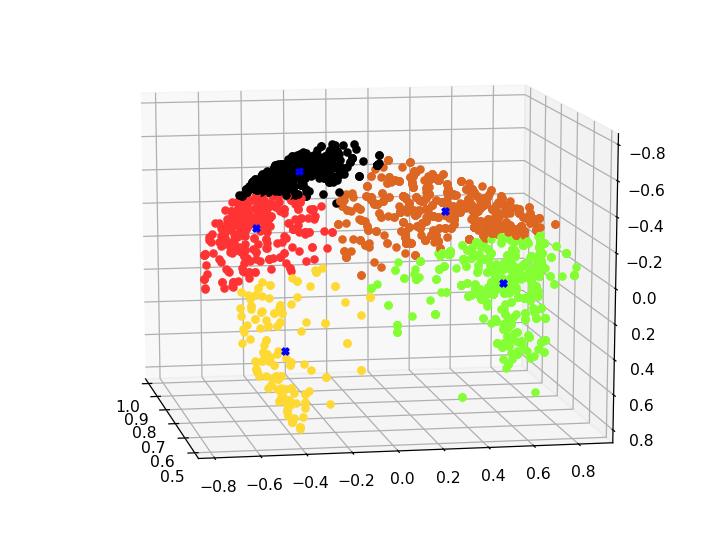

In [25]:
K = 5
alpha = grey_wolf_optimization()
print("DB Index        :"+str(davies_bouldin_index(alpha)))
print("Silhoutte Index :"+str(silhoutette_index(alpha)))
print("Calinski-Harabasz Index :"+str(calinski_harabasz(alpha)))
plot(alpha)

Generation 1: 100.73203308555676
Generation 2: 98.24698683113512
Generation 3: 97.31636507899267
Generation 4: 98.24580576550849
Generation 5: 97.0896902172664
Generation 6: 95.96923974431147
Generation 7: 96.05582618204731
Generation 8: 96.06107916731295
Generation 9: 95.0497712714774
Generation 10: 94.73952132103426
Generation 11: 95.44979599252453
Generation 12: 95.0738057357015
Generation 13: 95.0002950251421
Generation 14: 95.11109787113962
Generation 15: 95.43516049631576
Generation 16: 94.83544170265033
Generation 17: 94.94641124114933
Generation 18: 95.63644553517575
Generation 19: 95.38238600137481
Generation 20: 95.2229367580322
Generation 21: 95.24757138334161
Generation 22: 95.24757138334161
Generation 23: 95.24757138334164
Stopping GWO because same results over past 2 generations
Time taken: 98.0
DB Index        :0.8614558182395852
Silhoutte Index :0.9363104645752961
Calinski-Harabasz Index :7317.880839306939
423
391
496
452
128
163
248


<IPython.core.display.Javascript object>


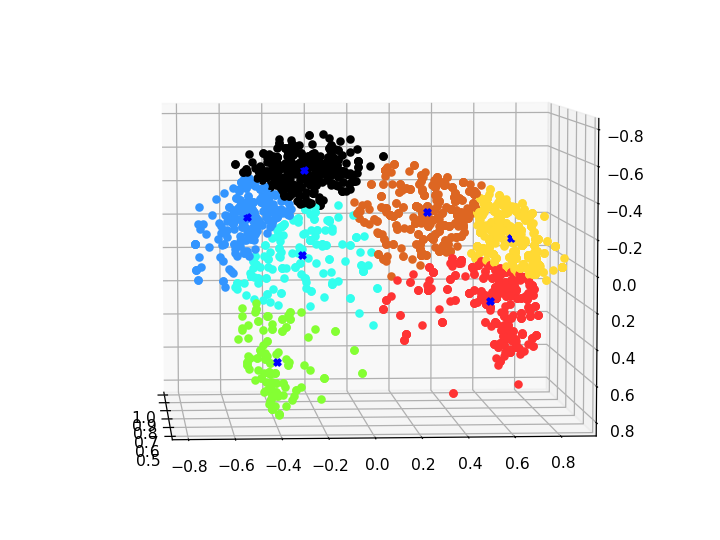

In [26]:
K = 7
alpha = grey_wolf_optimization()
print("DB Index        :"+str(davies_bouldin_index(alpha)))
print("Silhoutte Index :"+str(silhoutette_index(alpha)))
print("Calinski-Harabasz Index :"+str(calinski_harabasz(alpha)))
plot(alpha)

Generation 1: 170.6956286519509
Generation 2: 170.21576653270253
Generation 3: 165.8972001683013
Generation 4: 162.82176540850114
Generation 5: 161.08010967610812
Generation 6: 160.18087199601518
Generation 7: 159.50984648288053
Generation 8: 159.17461956761642
Generation 9: 159.23949374905965
Generation 10: 160.92593493081134
Generation 11: 160.47071609857153
Generation 12: 161.35014070439007
Generation 13: 161.58319802879706
Generation 14: 160.89295560919223
Generation 15: 160.60866876483797
Generation 16: 160.5389721863551
Generation 17: 161.0110665246572
Generation 18: 161.16238759026578
Generation 19: 161.16238759026578
Generation 20: 161.16238759026575
Stopping GWO because same results over past 2 generations
Time taken: 103.734375
DB Index        :0.9010544424495786
Silhoutte Index :0.9571652574424905
Calinski-Harabasz Index :6885.318609171797
374
329
124
240
111
109
371
378
265


<IPython.core.display.Javascript object>


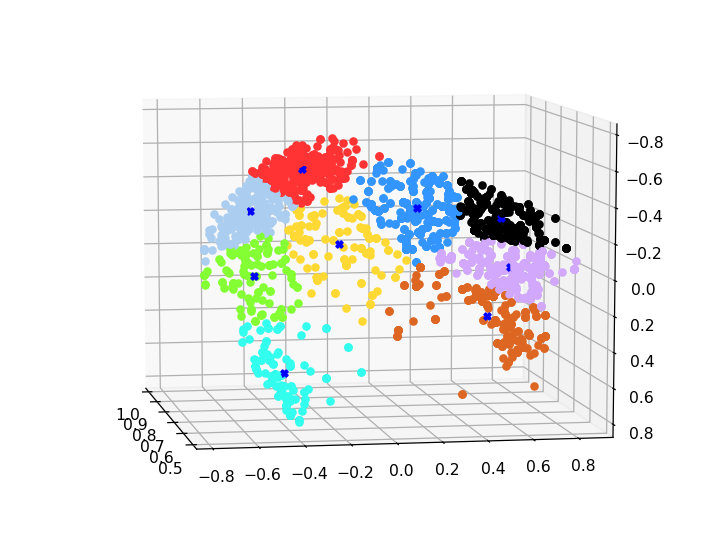

In [27]:
K = 9
alpha = grey_wolf_optimization()
print("DB Index        :"+str(davies_bouldin_index(alpha)))
print("Silhoutte Index :"+str(silhoutette_index(alpha)))
print("Calinski-Harabasz Index :"+str(calinski_harabasz(alpha)))
plot(alpha)